模型读入，一些预处理

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from utils import cifar10_load
import numpy as np

model_file = 'ResNet32_acc893.h5'
detector_file = 'detector_static.h5'
batch_size = 16
test_scale = 1024

(x_train, y_train), (x_dev, y_dev), (x_test, y_test) = cifar10_load()

Using TensorFlow backend.


In [2]:
model = keras.models.load_model(model_file)
detector = keras.models.load_model(detector_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


设定生成对抗样本的攻击参数

In [3]:
cw_params = {'batch_size': batch_size,
             'confidence': 10,
             'learning_rate': 0.1,
             'binary_search_steps': 5,
             'max_iterations': 1000,
             'abort_early': True,
             'initial_const': 0.01,
             'clip_min': 0.,
             'clip_max': 1.}

deepfool_params = {'nb_candidate': 10,
                   'overshoot': 0.02,
                   'max_iter': 50,
                   'clip_min': 0.,
                   'clip_max': 1.}

pgd_params = {'eps':0.3,
              'eps_iter':0.25, 
              'nb_iter':10, 
              'ord':np.inf,
              'clip_min':0., 
              'clip_max':1., 
              'rand_init':False,
              'sanity_checks':True}

lbfgs_params = {'batch_size':batch_size,
                'clip_min':0.,
                'clip_max':1.}

elasticnet_params = {'batch_size':batch_size,
                     'confidence':10,
                     'abort_early':True,
                     'clip_min':0.,
                     'clip_max':1.}

得到可以被正确分类的样本

In [4]:
correct_indexes = []
for i in range(len(x_test)):
    if np.argmax(model.predict(x_test[i].reshape(-1, 32, 32, 3))) == np.argmax(y_test[i]):
        correct_indexes.append(i)
    if len(correct_indexes) == test_scale: break

assert len(correct_indexes) == test_scale, "Test scale too large, can not find enough images."

sample_x = x_test[correct_indexes]
sample_y = y_test[correct_indexes]

对这些样本进行攻击，得到攻击成功的对抗样本

In [5]:
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import CarliniWagnerL2, DeepFool, ProjectedGradientDescent, ElasticNetMethod
from cleverhans.utils_tf import model_eval
from utils import initialize_uninitialized
from modified_lbfgs import LBFGS

model_wrap = KerasModelWrapper(model)
attacks = [LBFGS, CarliniWagnerL2, DeepFool, ProjectedGradientDescent,  ElasticNetMethod]
attack_params = [lbfgs_params, cw_params, deepfool_params, pgd_params,  elasticnet_params]

x = tf.placeholder(tf.float32, shape=(None,32,32,3))

attack_results = []
sess = keras.backend.get_session()
for attack, param in zip(attacks, attack_params):
    attack_wrap = attack(model_wrap, sess=sess)
    adv_x = attack_wrap.generate(x, **param)
    initialize_uninitialized(sess)
    adv_images = np.array([sess.run(adv_x, feed_dict={x: sample_x[i*batch_size:(i+1)*batch_size]}) for i in range(test_scale//batch_size)])
    adv_images = adv_images.reshape(-1,32,32,3)
    attack_results.append(adv_images)

/tf/cleverhans-master/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"


Instructions for updating:
Use tf.cast instead.


/tf/cleverhans-master/cleverhans/compat.py:23: UserWarning: <function reduce_max_v1 at 0x7f6c4a41f158> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/tf/cleverhans-master/cleverhans/compat.py:23: UserWarning: <function reduce_sum_v1 at 0x7f6c4a419400> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [6]:
for adv_images in attack_results:
    succeed_indexes = []
    for i in range(test_scale):
        if np.argmax(model.predict(adv_images[i].reshape(-1, 32, 32, 3))) != np.argmax(sample_y[i]):
            succeed_indexes.append(i)
    adv_images = adv_images[succeed_indexes]

这里验证发现所有攻击方式,均无攻击失败的情况

使用分类器对干净样本和对抗样本进行分类，得到分数，绘制ROC曲线

In [8]:
output_probs= []
true_label = []
for adv_images in attack_results:
    adv_prob = np.array([detector.predict(adv_image.reshape(-1, 32, 32, 3))[0][1] for adv_image in adv_images])
    clean_prob = np.array([detector.predict(clean_image.reshape(-1, 32, 32, 3))[0][1] for clean_image in sample_x])
    output_probs.append(np.concatenate([adv_prob, clean_prob]))
    true_label.append(np.concatenate([np.ones_like(adv_prob), np.zeros_like(clean_prob)]))

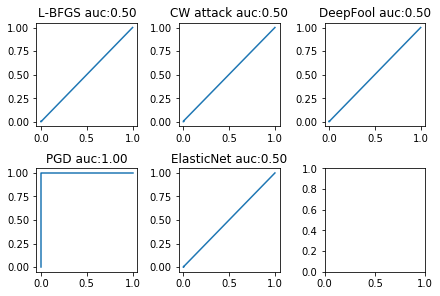

In [9]:
%matplotlib inline

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

attack_names = ['L-BFGS', 'CW attack', 'DeepFool', 'PGD', 'ElasticNet']
assert len(true_label) == len(output_probs), "Error due to in compatibility with label and probs"


fig, axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(output_probs)):
    fpr, tpr, thresholds = roc_curve(true_label[i], output_probs[i])
    roc_auc = auc(fpr, tpr)
    axs[i//3, i%3].plot(fpr, tpr)
    axs[i//3, i%3].set_title(attack_names[i]+' auc:%0.2f'%roc_auc)
plt.show()

In [7]:
np.save('../../pickles/advimages', np.array(attack_results))